<a href="https://colab.research.google.com/github/resquilleur/TestWorkNeowoxCC/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
# !git clone https://github.com/resquilleur/TestWorkNeowoxCC.git

# Часть 1. Загрузка и обработка данных. Подготовка наборов к обучению.

## Импорт библиотек

In [1]:
%cd TestWorkNeowoxCC

/content/TestWorkNeowoxCC


In [2]:
# !pip install pymorphy2

In [3]:
import pandas as pd
import numpy as np
import pymorphy2
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Загрузка и обработка наборов данных

In [4]:
# загрузим набор данных
data_train = pd.read_csv('data/for_test_train.csv').drop(columns=['Unnamed: 0'])
# посмотрим кол-во экземпляров по классам
data_train.groupby('label').count()

,message
label,
tag_do_not_call,85
tag_no,122
tag_no_now,1
tag_not_now,67
tag_what_company,36
tag_who_is,50
tag_yes,191


In [5]:
# видим, что у нас есть всего один экземпляр класса tag_no_now, по смыслу подходит к тегу tag_not_now
# я решил объеденить эти классы
data_train[data_train['label'] == 'tag_no_now']

,message,label
543,"ты шутишь, у меня нет времени!",tag_no_now


In [6]:
# получим индекс нужного тега и переименуем его в правильный тег
idx = (data_train['label'] == 'tag_no_now')
data_train.loc[idx, 'label'] = 'tag_not_now'
data_train.groupby('label').count()

,message
label,
tag_do_not_call,85
tag_no,122
tag_not_now,68
tag_what_company,36
tag_who_is,50
tag_yes,191


In [7]:
# загрузим проверочный набор данных
data_valid = pd.read_csv('data/for_test_valid.csv', sep=';') # обязательно использовать такой разделитель, иначе не загрузится.
data_valid # проверочный набор

,Unnamed: 0,message
0,106,зачем это надо
1,162,ну
2,602,какая организация?
3,32,во имя чего?
4,642,вы тут?
5,419,да ну вас!
6,854,"приветствую, а что за организация?"
7,59,да хорошо
8,219,с какой радости?
9,112,и что дальше?


## Аугментация данных

In [8]:
# видим дисбаланс классов и в целом датасет небольшой, сделаем аугментацию для повышения качество распознования классов
aug_data_train = pd.DataFrame() # создадим пустой датафрейм
labels = data_train['label'].unique() # список уникальных меток классов

# сделаем так, чтобы обязательно попали все примеры, и добавим сгенерированные бутстрапом, так чтобы в сумме оказалось 200 шт каждого класса
for label in labels:
    n_samples = 0
    aug_data_train = pd.concat([aug_data_train, data_train[data_train['label'] == label]], ignore_index=True)
    if label not in ['tag_yes', 'tag_no']:
        n_samples = 200 - data_train[data_train['label'] == label].count()[0]
    aug_data_train = pd.concat([aug_data_train, data_train[data_train['label'] == label].sample(n=n_samples, replace=True, random_state=42)], ignore_index=True)

aug_data_train

,message,label
0,будьте здоровы!,tag_no
1,не имеется,tag_no
2,ни фига,tag_no
3,вы бредите,tag_no
4,"нет, нашел дурака",tag_no
...,...,...
1108,скажите по новой,tag_who_is
1109,"да, алло, я не расслышал",tag_who_is
1110,"да, алло, я не расслышал",tag_who_is
1111,это кто?,tag_who_is


## Формируем наборы

In [9]:
# неагментированные данные
x_train_not_aug = data_train['message'].values
y_train_not_aug = data_train['label'].values

# формируем x_valid
x_valid = data_valid['message'].values

# формируем x_train, y_train
x_train = aug_data_train['message'].values
y_train = aug_data_train['label'].values

# сделаем one_hot_encoding для набора классов
ohe_ytrain = OneHotEncoder()
y_train = ohe_ytrain.fit_transform(y_train.reshape(-1,1)).toarray() # аугментированный набор
y_train[0]

array([0., 1., 0., 0., 0., 0.])

In [10]:
# функция приведения к нормальной форме слова
def data_normalized(x_data):
    x_data_normal = []
    for frase in x_data:
        new_frase = ''
        words = frase.split()
        for word in words:
            word = word.replace('!', '').replace(',', '').replace('?', '')
            new_frase += f' {ma.normal_forms(word)[0]}'
        x_data_normal.append(new_frase)
    return np.array(x_data_normal)

In [11]:
# создаем анализатор слов
ma = pymorphy2.MorphAnalyzer()

# далее у нас будет два варианта набора данных с нормой и без
x_valid_norm = data_normalized(x_valid)
x_train_norm = data_normalized(x_train)

In [12]:
# токенизируем слова без нормирования
tokenizer = Tokenizer()
tokenizer.fit_on_texts(np.concatenate((x_train, x_valid), axis=0)) # обучим на всех словах, что у нас есть

tokenizer_norm = Tokenizer()
tokenizer_norm.fit_on_texts(np.concatenate((x_train_norm, x_valid_norm), axis=0)) # обучим на всех словах, что у нас есть

# запоним длину словарей + 1 (так как еще 0-ой индекс добавим)
vocabulary_len = len(tokenizer.word_index)+1
vocabulary_norm_len = len(tokenizer_norm.word_index)+1

In [13]:
# индексы в последовательность, дополним нулями перед последовательностью
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad_seq = pad_sequences(x_train_seq, padding='pre')

x_train_seq_norm = tokenizer_norm.texts_to_sequences(x_train_norm)
x_train_pad_seq_norm = pad_sequences(x_train_seq_norm, padding='pre')

x_valid_seq = tokenizer.texts_to_sequences(x_valid)
x_valid_pad_seq = pad_sequences(x_valid_seq, padding='pre')

x_valid_seq_norm = tokenizer_norm.texts_to_sequences(x_valid_norm)
x_valid_pad_seq_norm = pad_sequences(x_valid_seq_norm, padding='pre')

In [14]:
# посмотрим что получилось
print(x_train_pad_seq[0])
print(x_train[0])

print(x_train_pad_seq_norm[0])
print(x_train_norm[0])

[  0   0   0   0   0   0   0 331 332]
будьте здоровы!
[  0   0   0   0   0   0   0 101 207]
 быть здоровый


In [15]:
# y_train общий сохраним для семплирования
y_train_full = y_train.copy()

# разобьем наборы на тестовый и тренировочный
# stratify позволяет сохранить баланс классов
x_train, x_test, y_train, y_test = train_test_split(x_train_pad_seq, y_train_full, test_size=0.2, stratify=y_train_full) 
x_train_norm, x_test_norm, y_train_norm, y_test_norm = train_test_split(x_train_pad_seq_norm, y_train_full, test_size=0.2, stratify=y_train_full)

# Часть 2. Обучение нейросетей

## Импорт библиотек

In [41]:
from TestWorkNeowoxCC.model_pack.model import *

import pandas as pd
import numpy as np

from tensorflow.keras.callbacks import ModelCheckpoint

## Создание сети

In [62]:
# используем фабрику для разных архитектур

fabric = ModelFabric()
model_lstm = fabric.create_model(name='lstm')
model_conv = fabric.create_model(name='conv')

## Обучение

Список параметров lstm включает:

* params[0] - название сети
* params[1] - длина словаря (вход embedding)
* params[2] - num classes
* params[3] - emb size coef
* params[4] - dropout
* params[5] - layers filters size
* params[6] - Adam learning_rate
* params[7] - Adam decay
* params[8] - размер batch_size
* params[9] - кол-во эпох

Список параметров conv включает:

* params[0] - название сети
* params[1] - длина словаря (вход embedding)
* params[2] - num classes
* params[3] - emb size coef
* params[4] - dropout
* params[5] - layers kernel size
* params[6] - layers filters size
* params[7] - max pool filters size
* params[8] - dense kernel size
* params[9] - Adam learning_rate
* params[10] - Adam decay
* params[11] - размер batch_size
* params[12] - кол-во эпох

In [63]:
# выберем два набора параметров (лучше всего показали себя на тестах) - тут можно реализовать генетику
models_params_list = [['lstm64', vocabulary_len, y_train.shape[1], 1, 7, 6, 1e-3, 1e-6, 16, 30],
                      ['lstm128', vocabulary_len, y_train.shape[1], 1, 7, 7, 1e-3, 1e-6, 32, 30],
                      ['conv64', vocabulary_len, y_train.shape[1], 1, 5, 6, 3, 3, 10, 1e-3, 1e-6, 16, 30],
                      ['conv128', vocabulary_len, y_train.shape[1], 1, 5, 7, 3, 3, 10, 1e-3, 1e-6, 32, 30]]

models = {} # тут будут лежать обученные модели
historys = {} # тут будут лежать истрии обучения

### Обучение на аугментированых данных без нормальной формы

In [64]:
# обучение

for params in models_params_list:
    
    # имя файла у каждой модели свое, сохраним лучшие веса
    model_checkpoint_callback = ModelCheckpoint(
        filepath=f'data/best_weights_{params[0]}.h5',
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
        
    if 'lstm' in params[0]:
        # генерим нужную архитектуру
        model = model_lstm.make_architecture(params[1:6])

        # компилируем модель
        model.compile(optimizer=Adam(learning_rate=params[6], decay=params[7]), loss='categorical_crossentropy', metrics=['accuracy'])

        # обучаем verbose=0
        history = model.fit(
            x_train,
            y_train,
            batch_size=params[8],
            epochs=params[9],
            validation_data=(x_test, y_test),
            callbacks=model_checkpoint_callback,
            verbose=0
            )
    
    if 'conv' in params[0]:
        # генерим нужную архитектуру
        model = model_conv.make_architecture(params[1:9])

        # компилируем модель
        model.compile(optimizer=Adam(learning_rate=params[9], decay=params[10]), loss='categorical_crossentropy', metrics=['accuracy'])

        # обучаем verbose=0
        history = model.fit(
            x_train,
            y_train,
            batch_size=params[11],
            epochs=params[12],
            validation_data=(x_test, y_test),
            callbacks=model_checkpoint_callback,
            verbose=0
            )
    
    models[params[0]] = model
    historys[params[0]] = history

### Обучение на аугментированых данных в нормальной форме

In [65]:
for params in models_params_list:
    
    # имя файла у каждой модели свое, сохраним лучшие веса
    model_checkpoint_callback = ModelCheckpoint(
        filepath=f'data/best_weights_{params[0]}_norm.h5',
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

       
    if 'lstm' in params[0]:
        # генерим нужную архитектуру
        model = model_lstm.make_architecture(params[1:6])

        # компилируем модель
        model.compile(optimizer=Adam(learning_rate=params[6], decay=params[7]), loss='categorical_crossentropy', metrics=['accuracy'])

        # обучаем verbose=0
        history = model.fit(
            x_train_norm,
            y_train_norm,
            batch_size=params[8],
            epochs=params[9],
            validation_data=(x_test_norm, y_test_norm),
            callbacks=model_checkpoint_callback,
            verbose=0
            )
    
    if 'conv' in params[0]:
        # генерим нужную архитектуру
        model = model_conv.make_architecture(params[1:9])

        # компилируем модель
        model.compile(optimizer=Adam(learning_rate=params[9], decay=params[10]), loss='categorical_crossentropy', metrics=['accuracy'])

        # обучаем verbose=0
        history = model.fit(
            x_train_norm,
            y_train_norm,
            batch_size=params[11],
            epochs=params[12],
            validation_data=(x_test_norm, y_test_norm),
            callbacks=model_checkpoint_callback,
            verbose=0
            )
    
    models[params[0]+'_norm'] = model
    historys[params[0]+'_norm'] = history

## Вывод результатов

### Посмотрим графики обучения для анализа

In [66]:
import matplotlib.pyplot as plt

Накопительный график loss по эпохам модели:lstm64


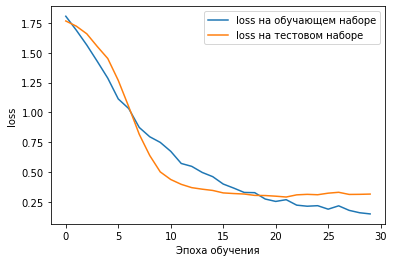

Накопительный график loss по эпохам модели:lstm128


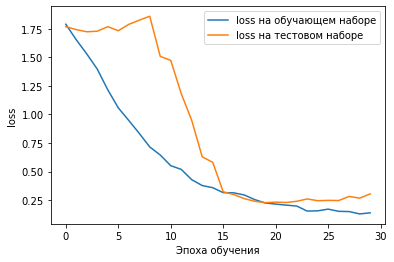

Накопительный график loss по эпохам модели:conv64


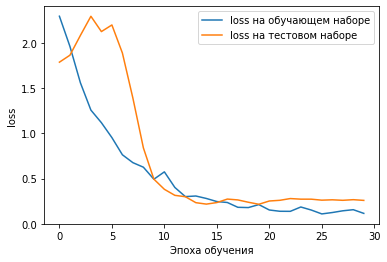

Накопительный график loss по эпохам модели:conv128


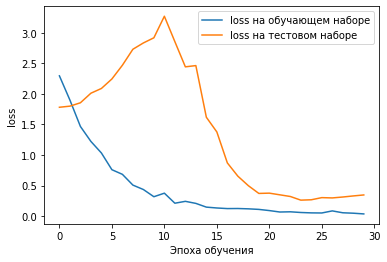

Накопительный график loss по эпохам модели:lstm64_norm


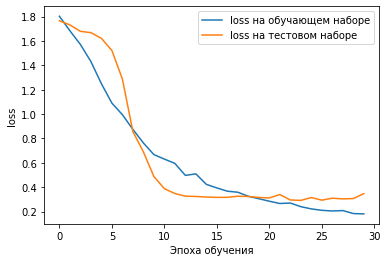

Накопительный график loss по эпохам модели:lstm128_norm


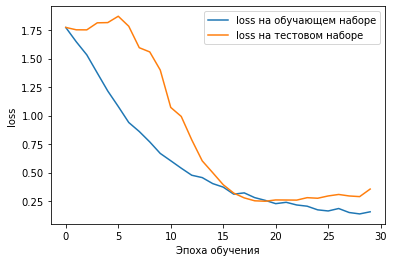

Накопительный график loss по эпохам модели:conv64_norm


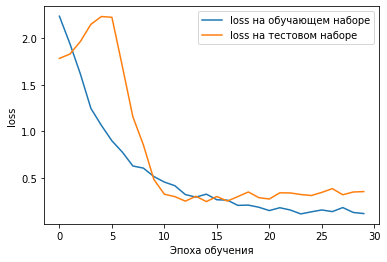

Накопительный график loss по эпохам модели:conv128_norm


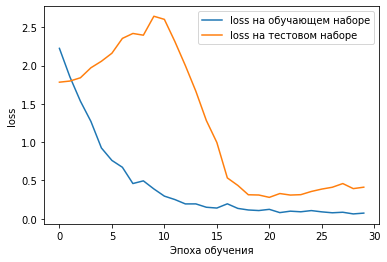

In [67]:
# посмотрим графики 128 сеть менее переобучилась
# посмотрим графики нормированных данных, как видим у 128 сети нет переобучения
for key in historys.keys():
    print(f'Накопительный график loss по эпохам модели:{key}')
    plt.plot(historys[key].history['loss'], 
            label='loss на обучающем наборе')
    plt.plot(historys[key].history['val_loss'], 
            label='loss на тестовом наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

### Вывод рузельтатов

In [68]:
from IPython.display import display

In [69]:
# функция вывода результатов получает на вход модель x_test, y_test
def getResults(model, x_test, y_test):
    pred_model = model.predict(x_test) # получаем предсказание модели
    pred = np.argmax(pred_model, axis=1) # получаем метку класса с максимальным значением
    result = np.zeros((y_test.shape[1], 2)) # сделаем пустой numpy массив для записи результатов

    # проходимся по всей длине предсказаний
    for i in range(pred.shape[0]):
        # получаем индекс элемента, где у нас 1
        y_true_class_indx = list(y_test[i]).index(max(list(y_test[i])))
        if pred[i] == y_true_class_indx: # если предсказание верно, то увеличиваем счетчик в первом столбце, в строке номера индекса
            result[y_true_class_indx, 0] += 1
        else: # если не верно, то увеличиваем счетчик второго столбца
            result[y_true_class_indx, 1] += 1
    
    # готовим датафрейм с результатами
    result_test_df = pd.DataFrame(result, columns=['true', 'false'])
    result_test_df['percent_true'] = result_test_df['true'] / (result_test_df['true'] + result_test_df['false']) * 100 # считаем процент правильных предсказаний
    result_test_df['tag_name'] = [x[3:] for x in ohe_ytrain.get_feature_names()]
    result_mean = result_test_df['percent_true'].mean()
    print(f'Средний процент правильных предсказаний по всем классам составил: {result_mean}')
    print(result_test_df)
    return pred_model

In [71]:
# функция вывода результата по проверочному набору
def getValidResultsTable(model, valid):
    pred = model.predict(valid) # получаем предсказание модели

    valid_df = pd.DataFrame()
    valid_df['massege'] = list(x_valid) # изначальный набор предложений для проверки
    valid_df['softmax'] = list(pred.round(2)) # записываем вероятности классов
    valid_df['class'] = list(np.argmax(pred, axis=1)) # получаем предсказание по максимальному классу
    valid_df['class'] = np.array([x[3:] for x in ohe_ytrain.get_feature_names()])[valid_df['class']] # проставляем название тега
    display(valid_df)
    return valid_df

In [72]:
# загрузим лучшие веса моделей, получим предсказания на тесовых данных, выведем предсказания на валидационных данных
for key in models.keys():
    models[key].load_weights(f'data/best_weights_{key}.h5')
    model = models[key]
    print(f'Модель {key}')
    if 'norm' in key:
        getResults(model, x_test_norm, y_test_norm)
        valid_df = getValidResultsTable(model, x_valid_pad_seq_norm)
    else:
        getResults(model, x_test, y_test)
        valid_df = getValidResultsTable(model, x_valid_pad_seq)
    valid_df.to_csv(f'data/{key}.csv')
    print()
    print()

Модель lstm64
Средний процент правильных предсказаний по всем классам составил: 86.57894736842105
   true  false  percent_true          tag_name
0  37.0    3.0     92.500000   tag_do_not_call
1  10.0   15.0     40.000000            tag_no
2  40.0    0.0    100.000000       tag_not_now
3  40.0    0.0    100.000000  tag_what_company
4  39.0    1.0     97.500000        tag_who_is
5  34.0    4.0     89.473684           tag_yes


,massege,softmax,class
0,зачем это надо,"[0.0, 0.0, 0.0, 0.0, 0.3, 0.7]",tag_yes
1,ну,"[0.04, 0.02, 0.0, 0.0, 0.0, 0.94]",tag_yes
2,какая организация?,"[0.03, 0.11, 0.0, 0.08, 0.03, 0.75]",tag_yes
3,во имя чего?,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.99]",tag_yes
4,вы тут?,"[0.02, 0.13, 0.0, 0.16, 0.21, 0.48]",tag_yes
5,да ну вас!,"[0.04, 0.03, 0.0, 0.0, 0.0, 0.92]",tag_yes
6,"приветствую, а что за организация?","[0.01, 0.06, 0.0, 0.83, 0.04, 0.07]",tag_what_company
7,да хорошо,"[0.01, 0.03, 0.0, 0.0, 0.0, 0.97]",tag_yes
8,с какой радости?,"[0.01, 0.06, 0.0, 0.0, 0.0, 0.92]",tag_yes
9,и что дальше?,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes




Модель lstm128
Средний процент правильных предсказаний по всем классам составил: 91.45614035087719
   true  false  percent_true          tag_name
0  36.0    4.0     90.000000   tag_do_not_call
1  16.0    9.0     64.000000            tag_no
2  40.0    0.0    100.000000       tag_not_now
3  40.0    0.0    100.000000  tag_what_company
4  40.0    0.0    100.000000        tag_who_is
5  36.0    2.0     94.736842           tag_yes


,massege,softmax,class
0,зачем это надо,"[0.0, 0.05, 0.0, 0.0, 0.15, 0.8]",tag_yes
1,ну,"[0.02, 0.02, 0.0, 0.0, 0.0, 0.96]",tag_yes
2,какая организация?,"[0.02, 0.19, 0.0, 0.0, 0.01, 0.78]",tag_yes
3,во имя чего?,"[0.0, 0.02, 0.0, 0.0, 0.0, 0.97]",tag_yes
4,вы тут?,"[0.01, 0.56, 0.0, 0.0, 0.05, 0.37]",tag_no
5,да ну вас!,"[0.02, 0.03, 0.0, 0.0, 0.0, 0.95]",tag_yes
6,"приветствую, а что за организация?","[0.0, 0.61, 0.0, 0.1, 0.12, 0.17]",tag_no
7,да хорошо,"[0.0, 0.03, 0.0, 0.0, 0.0, 0.97]",tag_yes
8,с какой радости?,"[0.01, 0.11, 0.0, 0.0, 0.0, 0.88]",tag_yes
9,и что дальше?,"[0.0, 0.02, 0.0, 0.0, 0.0, 0.98]",tag_yes




Модель conv64
Средний процент правильных предсказаний по всем классам составил: 91.9342105263158
   true  false  percent_true          tag_name
0  35.0    5.0     87.500000   tag_do_not_call
1  18.0    7.0     72.000000            tag_no
2  40.0    0.0    100.000000       tag_not_now
3  40.0    0.0    100.000000  tag_what_company
4  40.0    0.0    100.000000        tag_who_is
5  35.0    3.0     92.105263           tag_yes


,massege,softmax,class
0,зачем это надо,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
1,ну,"[0.02, 0.03, 0.0, 0.0, 0.0, 0.95]",tag_yes
2,какая организация?,"[0.0, 0.03, 0.01, 0.0, 0.0, 0.96]",tag_yes
3,во имя чего?,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
4,вы тут?,"[0.01, 0.49, 0.0, 0.0, 0.01, 0.49]",tag_yes
5,да ну вас!,"[0.02, 0.02, 0.0, 0.0, 0.0, 0.96]",tag_yes
6,"приветствую, а что за организация?","[0.0, 0.05, 0.0, 0.04, 0.0, 0.9]",tag_yes
7,да хорошо,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.99]",tag_yes
8,с какой радости?,"[0.0, 0.03, 0.0, 0.0, 0.0, 0.96]",tag_yes
9,и что дальше?,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes




Модель conv128
Средний процент правильных предсказаний по всем классам составил: 89.64473684210526
   true  false  percent_true          tag_name
0  37.0    3.0     92.500000   tag_do_not_call
1  12.0   13.0     48.000000            tag_no
2  40.0    0.0    100.000000       tag_not_now
3  40.0    0.0    100.000000  tag_what_company
4  40.0    0.0    100.000000        tag_who_is
5  37.0    1.0     97.368421           tag_yes


,massege,softmax,class
0,зачем это надо,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
1,ну,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.99]",tag_yes
2,какая организация?,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.99]",tag_yes
3,во имя чего?,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
4,вы тут?,"[0.01, 0.55, 0.01, 0.0, 0.03, 0.4]",tag_no
5,да ну вас!,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
6,"приветствую, а что за организация?","[0.0, 0.1, 0.0, 0.05, 0.04, 0.81]",tag_yes
7,да хорошо,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
8,с какой радости?,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
9,и что дальше?,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes




Модель lstm64_norm
Средний процент правильных предсказаний по всем классам составил: 88.07894736842105
   true  false  percent_true          tag_name
0  40.0    0.0    100.000000   tag_do_not_call
1  11.0   14.0     44.000000            tag_no
2  40.0    0.0    100.000000       tag_not_now
3  40.0    0.0    100.000000  tag_what_company
4  38.0    2.0     95.000000        tag_who_is
5  34.0    4.0     89.473684           tag_yes


,massege,softmax,class
0,зачем это надо,"[0.0, 0.02, 0.0, 0.0, 0.07, 0.91]",tag_yes
1,ну,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.99]",tag_yes
2,какая организация?,"[0.0, 0.0, 0.0, 0.98, 0.0, 0.02]",tag_what_company
3,во имя чего?,"[0.0, 0.13, 0.0, 0.0, 0.0, 0.86]",tag_yes
4,вы тут?,"[0.07, 0.16, 0.0, 0.0, 0.0, 0.76]",tag_yes
5,да ну вас!,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.99]",tag_yes
6,"приветствую, а что за организация?","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",tag_what_company
7,да хорошо,"[0.0, 0.08, 0.0, 0.0, 0.0, 0.92]",tag_yes
8,с какой радости?,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
9,и что дальше?,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes




Модель lstm128_norm
Средний процент правильных предсказаний по всем классам составил: 89.64035087719299
   true  false  percent_true          tag_name
0  39.0    1.0     97.500000   tag_do_not_call
1  14.0   11.0     56.000000            tag_no
2  40.0    0.0    100.000000       tag_not_now
3  40.0    0.0    100.000000  tag_what_company
4  39.0    1.0     97.500000        tag_who_is
5  33.0    5.0     86.842105           tag_yes


,massege,softmax,class
0,зачем это надо,"[0.02, 0.06, 0.0, 0.0, 0.04, 0.87]",tag_yes
1,ну,"[0.01, 0.03, 0.0, 0.0, 0.0, 0.95]",tag_yes
2,какая организация?,"[0.0, 0.01, 0.0, 0.61, 0.0, 0.37]",tag_what_company
3,во имя чего?,"[0.0, 0.16, 0.01, 0.0, 0.0, 0.83]",tag_yes
4,вы тут?,"[0.08, 0.5, 0.0, 0.0, 0.03, 0.38]",tag_no
5,да ну вас!,"[0.02, 0.08, 0.0, 0.0, 0.0, 0.89]",tag_yes
6,"приветствую, а что за организация?","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",tag_what_company
7,да хорошо,"[0.01, 0.05, 0.0, 0.0, 0.0, 0.93]",tag_yes
8,с какой радости?,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.99]",tag_yes
9,и что дальше?,"[0.0, 0.02, 0.0, 0.0, 0.0, 0.98]",tag_yes




Модель conv64_norm
Средний процент правильных предсказаний по всем классам составил: 89.60087719298247
   true  false  percent_true          tag_name
0  40.0    0.0    100.000000   tag_do_not_call
1  12.0   13.0     48.000000            tag_no
2  40.0    0.0    100.000000       tag_not_now
3  40.0    0.0    100.000000  tag_what_company
4  39.0    1.0     97.500000        tag_who_is
5  35.0    3.0     92.105263           tag_yes


,massege,softmax,class
0,зачем это надо,"[0.0, 0.01, 0.0, 0.0, 0.02, 0.97]",tag_yes
1,ну,"[0.03, 0.03, 0.0, 0.0, 0.0, 0.93]",tag_yes
2,какая организация?,"[0.01, 0.14, 0.02, 0.52, 0.0, 0.3]",tag_what_company
3,во имя чего?,"[0.02, 0.89, 0.02, 0.0, 0.0, 0.06]",tag_no
4,вы тут?,"[0.12, 0.14, 0.0, 0.0, 0.05, 0.69]",tag_yes
5,да ну вас!,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.99]",tag_yes
6,"приветствую, а что за организация?","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",tag_what_company
7,да хорошо,"[0.0, 0.02, 0.0, 0.0, 0.0, 0.97]",tag_yes
8,с какой радости?,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.99]",tag_yes
9,и что дальше?,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.98]",tag_yes




Модель conv128_norm
Средний процент правильных предсказаний по всем классам составил: 89.6842105263158
   true  false  percent_true          tag_name
0  39.0    1.0     97.500000   tag_do_not_call
1  14.0   11.0     56.000000            tag_no
2  38.0    2.0     95.000000       tag_not_now
3  40.0    0.0    100.000000  tag_what_company
4  39.0    1.0     97.500000        tag_who_is
5  35.0    3.0     92.105263           tag_yes


,massege,softmax,class
0,зачем это надо,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.99]",tag_yes
1,ну,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.99]",tag_yes
2,какая организация?,"[0.0, 0.0, 0.0, 0.02, 0.0, 0.98]",tag_yes
3,во имя чего?,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.99]",tag_yes
4,вы тут?,"[0.02, 0.28, 0.0, 0.0, 0.03, 0.66]",tag_yes
5,да ну вас!,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.99]",tag_yes
6,"приветствую, а что за организация?","[0.0, 0.09, 0.0, 0.57, 0.0, 0.33]",tag_what_company
7,да хорошо,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.99]",tag_yes
8,с какой радости?,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
9,и что дальше?,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes


# Выводы.

 Создан гибкий инструмент для проверки гипотез. Развитием дальше может быть настройка кол-ва и типов слоев и их сочетаний, а так же подключение генетики для поиска оптимальных архитектур.

 Лучше всего себя показали ltm 128 norm и conv 64 norm, отправляю файл от lstm128norm, так как она поувереннее в спорных ситуациях.